[Notebook of task](https://github.com/DistributedSystemsGroup/Algorithmic-Machine-Learning/blob/master/Challenges/Anomaly_Detection/anomaly_detection_challenge.ipynb)

In [1]:
import os
import sys
import re
import random
import matplotlib
import implicit
import warnings
# For data manipulation
import pandas as pd
import numpy as np
# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
# For prediction
from tqdm import tqdm

basepath = "/mnt/datasets/anomaly/"

In [2]:
column_names = [
    "SessionNumber", 
    "SystemID",
    "Date",
    "HighPriorityAlerts", 
    "Dumps",
    "CleanupOOMDumps",
    "CompositeOOMDums",
    "IndexServerRestarts",
    "NameServerRestarts",
    "XSEngineRestarts",
    "PreprocessorRestarts",
    "DaemonRestarts",
    "StatisticsServerRestarts",
    "CPU",
    "PhysMEM",
    "InstanceMEM",
    "TablesAllocation", 
    "IndexServerAllocationLimit",
    "ColumnUnloads",
    "DeltaSize",
    "MergeErrors",
    "BlockingPhaseSec", 
    "Disk",
    "LargestTableSize",
    "LargestPartitionSize",
    "DiagnosisFiles",
    "DiagnosisFilesSize",
    "DaysWithSuccessfulDataBackups",
    "DaysWithSuccessfulLogBackups",
    "DaysWithFailedDataBackups",
    "DaysWithFailedfulLogBackups",
    "MinDailyNumberOfSuccessfulDataBackups",
    "MinDailyNumberOfSuccessfulLogBackups",
    "MaxDailyNumberOfFailedDataBackups",
    "MaxDailyNumberOfFailedLogBackups",
    "LogSegmentChange",
    "Check1",
    "Check2",
    "Check3",
    "Check4",
    "Check5",
    "Check6",
    "Check7",
    "Check8"
]

labels = ["Check1", "Check2", "Check3", "Check4", "Check5", "Check6", "Check7", "Check8"]

In [3]:
dataDF = pd.read_csv(basepath + 'data.csv', delimiter=";", header=None, names=column_names)

In [4]:
dataDF.head()

,SessionNumber,SystemID,Date,HighPriorityAlerts,Dumps,CleanupOOMDumps,CompositeOOMDums,IndexServerRestarts,NameServerRestarts,XSEngineRestarts,...,MaxDailyNumberOfFailedLogBackups,LogSegmentChange,Check1,Check2,Check3,Check4,Check5,Check6,Check7,Check8
0,0,0,16/01/2017 04:04,1,0.0,0.0,0.0,0,0,0,...,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
1,1,1,06/02/2017 04:03,0,0.0,0.0,0.0,0,0,0,...,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2,2,1,20/02/2017 04:03,0,0.0,0.0,0.0,0,0,0,...,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
3,3,2,13/02/2017 04:44,1,0.0,0.0,0.0,0,0,0,...,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
4,4,3,06/02/2017 04:31,1,0.0,0.0,0.0,0,0,0,...,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0


In [5]:
# create pure data DF
puredataDF = dataDF.drop(labels, axis=1)

#create a copy of the label columns for exploration
anomaliesDF = dataDF.filter(labels, axis=1)

# percentage of NA in each label 
print(anomaliesDF.isna().mean().round(4) * 100) 

anomaliesDF_withoutNA = anomaliesDF.fillna(0)

Check1     8.54
Check2     8.53
Check3     7.86
Check4    12.77
Check5    12.21
Check6     2.57
Check7    12.45
Check8     0.02
dtype: float64


The different labels have a lot of NaN values. Should these be removed? Or should we handle each label individually and only use the rows without NaNs for that label? The simplest solution is to fill them with 0's.

Text(0.5,1,'Corrolation matrix of the 8 different labels')

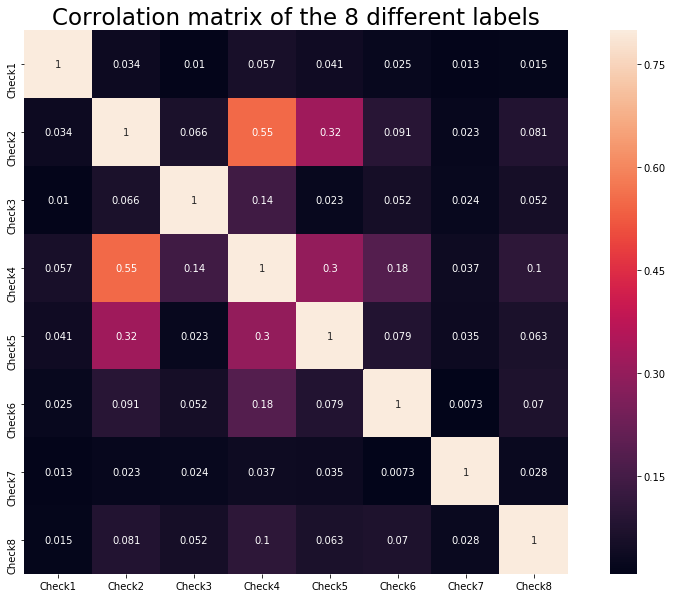

In [6]:
#sns.set(font_scale=1.3)

corr_matrix_anomalies = anomaliesDF.corr()
figure, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix_anomalies, vmax=0.8, annot=True, square=True)
plt.title('Corrolation matrix of the 8 different labels', fontsize=23)


### Things to note from corr matrix of the different labels
- Check4 and Check2 have a corrolation of 0.55. It could be wise to make one model to predict these two together.
- Check5 and Check2 have a corrolation of 0.32
- Check5 and Check4 have a corrolation of 0.3
- Maybe all three together?

In [7]:
#counted_anomaliesDF = anomaliesDF_withoutNA.apply(pd.value_counts)
counted_anomaliesDF = anomaliesDF.apply(pd.value_counts)

In [8]:
counted_anomaliesDF.loc["Total"] = counted_anomaliesDF.sum()
counted_anomaliesDF.loc["PercentageAnomalies"] = (counted_anomaliesDF.iloc[1] / counted_anomaliesDF.iloc[2]).round(5)*100


In [9]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

counted_anomaliesDF

,Check1,Check2,Check3,Check4,Check5,Check6,Check7,Check8
0.0,260884.00,253781.00,256370.00,225569.00,248917.00,199075.00,243621.00,284060.00
1.0,1636.00,8764.00,8093.00,24815.00,3080.00,80572.00,7688.00,2919.00
Total,262520.00,262545.00,264463.00,250384.00,251997.00,279647.00,251309.00,286979.00
PercentageAnomalies,0.62,3.34,3.06,9.91,1.22,28.81,3.06,1.02


In [28]:
names = []

for row in anomaliesDF_withoutNA.itertuples():
    l = []
    if row.Check1 == 1:
        l.append("Check1")
    if row.Check2 == 1:
        l.append("Check2")
    if row.Check3 == 1:
        l.append("Check3")
    if row.Check4 == 1:
        l.append("Check4")
    if row.Check5 == 1:
        l.append("Check5")
    if row.Check6 == 1:
        l.append("Check6")
    if row.Check7 == 1:
        l.append("Check7")
    if row.Check8 == 1:
        l.append("Check8")
    names.append(l)

    
plotDF = anomaliesDF_withoutNA
plotDF['Names'] = names

In [41]:
rowSums = dataDF.iloc[:,36:].sum(axis=1)

plotDF["RowSums"] = rowSums

rowSums = plotDF["RowSums"].value_counts()
rowSums

0.00    184547
1.00     78435
2.00     15721
3.00      6059
4.00      1895
5.00       319
6.00        47
7.00         8
Name: RowSums, dtype: int64

Text(0.5,1,'Number of observations with one or more anomaly')

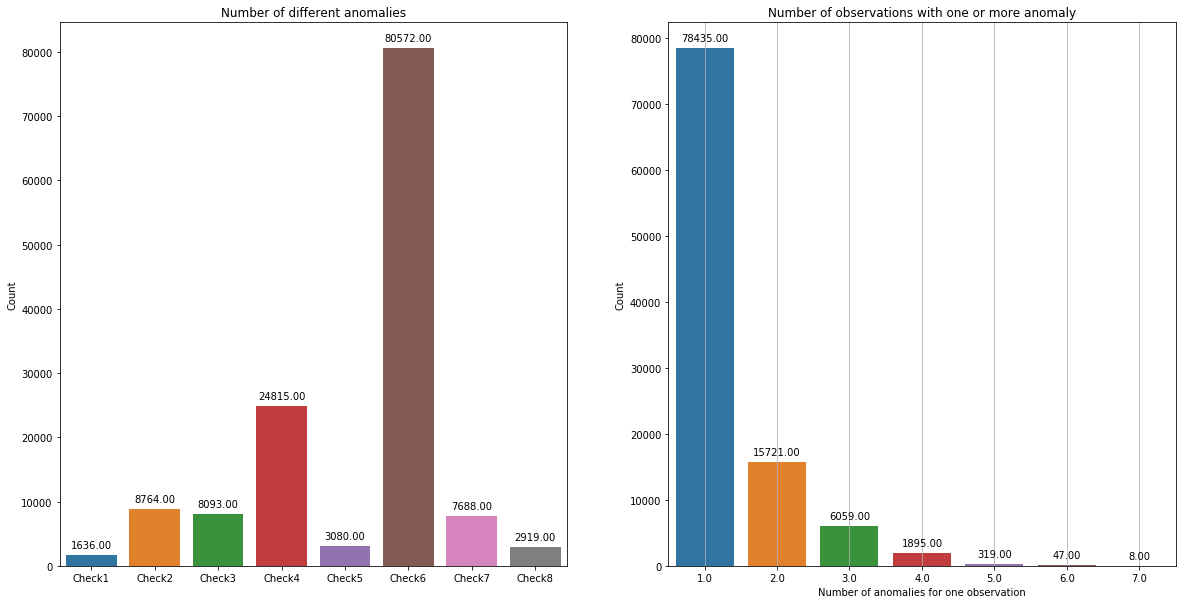

In [30]:
y1 = counted_anomaliesDF.loc[1.0]
x1 = labels

figure = plt.figure(figsize=(20,10))
ax1 = figure.add_subplot(1,2,1)
ax2 = figure.add_subplot(1,2,2)

b1 = sns.barplot(y=y1, x=x1, ax=ax1)
plt.grid()

for p in b1.patches:
    b1.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

b2 = sns.barplot(x=multiLabel_counts.index, y=multiLabel_counts.values, ax=ax2)
plt.grid()

for p in b2.patches:
    b2.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

ax1.set_ylabel('Count')
ax1.set_title('Number of different anomalies')

ax2.set_xlabel('Number of anomalies for one observation')
ax2.set_ylabel('Count')
ax2.set_title('Number of observations with one or more anomaly')

## Exploration of data (not labels)

In [43]:
# percentage of NA in each label 
print(puredataDF.isna().mean().round(4) * 100) 

SessionNumber                            0.00
SystemID                                 0.00
Date                                     0.00
HighPriorityAlerts                       0.00
Dumps                                    0.00
CleanupOOMDumps                          0.00
CompositeOOMDums                         0.00
IndexServerRestarts                      0.00
NameServerRestarts                       0.00
XSEngineRestarts                         0.00
PreprocessorRestarts                     0.00
DaemonRestarts                           0.00
StatisticsServerRestarts                 0.00
CPU                                      8.78
PhysMEM                                  7.17
InstanceMEM                              7.71
TablesAllocation                         0.80
IndexServerAllocationLimit               9.21
ColumnUnloads                            0.00
DeltaSize                                0.07
MergeErrors                              2.69
BlockingPhaseSec                  

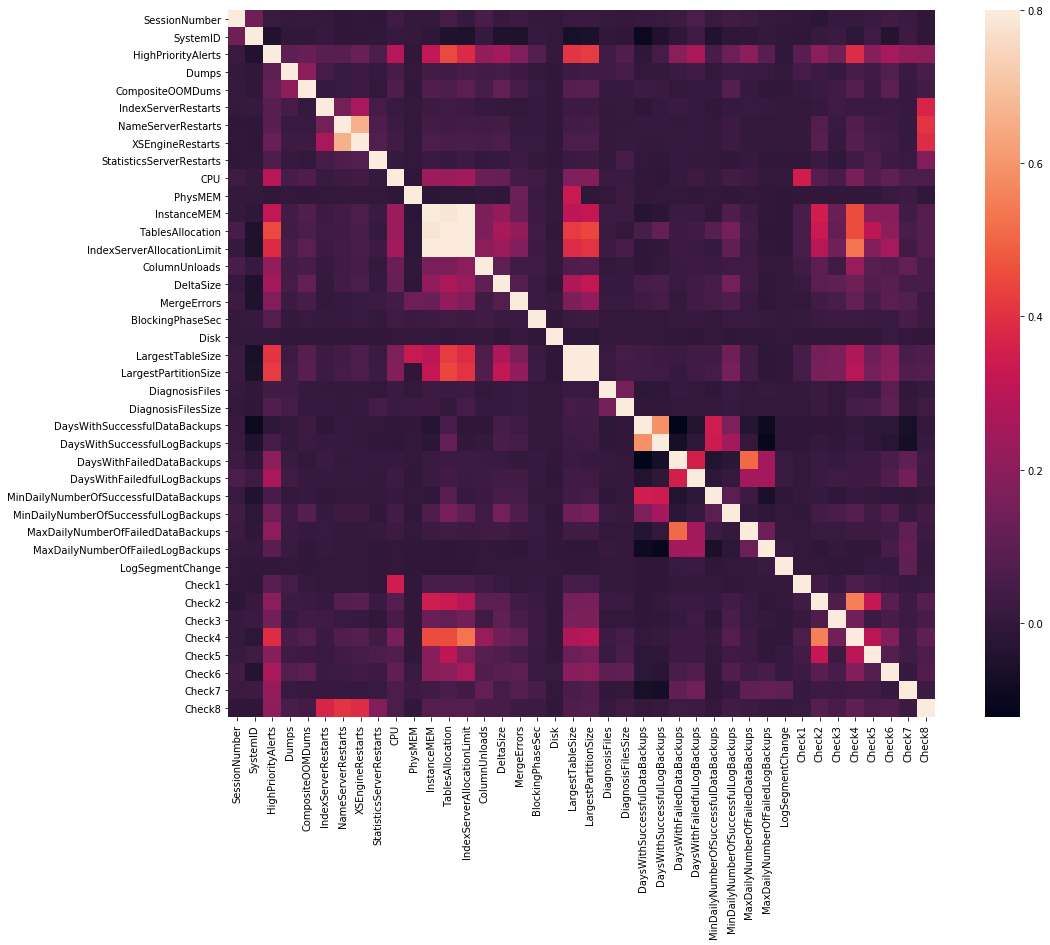

In [52]:

matrixDF = dataDF.drop(["CleanupOOMDumps","PreprocessorRestarts", "DaemonRestarts"], axis=1)
corr_matrix_puredata = matrixDF.corr()
figure, ax = plt.subplots(figsize=(18,13))
ax = sns.heatmap(corr_matrix_puredata, vmax=0.8, square=True)


# Data preprocessing

In [42]:
# drop column with lots of NaNs
#processed_dataDF = dataDF.drop(["BlockingPhaseSec"],axis=1)

In [57]:
puredata_labels = list(puredataDF)

#drops from 287031 rows to 196374
dataDF = dataDF.dropna(axis=0, how='any', subset=puredata_labels)


(287031, 44)
(196374, 44)


In [63]:
check1DF = dataDF.drop(labels-["Check1"], axis=1)
check1DF = dataDF.dropna(axis=0, how='any', subset=["Check1"])

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [61]:
X = dataDF.drop(labels, axis=1)
y = dataDF.filter(labels, axis=1)
print(X.shape)
print(y.shape)

(196374, 36)
(196374, 8)


In [62]:
print(X.isnull().sum().any())
print(y.isnull().sum().any())

False
True


In [ ]:
from sklearn.model_selection import train_test_split

# Divide train data into train and validation sets

seed = 42
test_size = 0.20

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = test_size, random_state = seed)

# Modeling

- https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff


### Multi-label classification
- Decide Evaluation Metric
   - F1 Macro/Micro
   - Hamming-Loss
   - Exact Match Ratio
- Several binary classifiers vs. one multi-label
    - OnevsRest
    - Binary Relevance
    - Classifier Chains
    - Label Powerset
    - Adapted Algorithm

### Normalization and PCA

In [ ]:
# PCA performs best with a normalized feature set 
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()  
scaled_X_train = sc.fit_transform(X_train)  
scaled_X_test = sc.transform(X_test)  


from sklearn.decomposition import PCA

pca = PCA(.99)  
pca_X_train = pca.fit_transform(scaled_X_train)  
pca_X_test = pca.transform(scaled_X_test)  

In [ ]:
from sklearn.ensemble import IsolationForest

fig, axs = plt.subplots(1, 6, figsize=(25, 25), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i, column in enumerate(cols):
    isolation_forest = IsolationForest(contamination='auto')
    isolation_forest.fit(df[column].values.reshape(-1,1))

    xx = np.linspace(df[column].min(), df[column].max(), len(df)).reshape(-1,1)
    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)
    
    axs[i].plot(xx, anomaly_score, label='anomaly score')
    axs[i].fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                     where=outlier==-1, color='r', 
                     alpha=.4, label='outlier region')
    axs[i].legend()
    axs[i].set_title(column)

